In [2]:
!pip install -q torch==2.1.0+cu118 torchvision==0.16.0+cu118 torchaudio==2.1.0 --index-url https://download.pytorch.org/whl/cu118
!pip install -q pyg_lib torch_scatter torch_sparse torch_cluster torch_spline_conv -f https://data.pyg.org/whl/torch-2.1.0+cu118.html
!pip install -q torch_geometric

ERROR: Could not find a version that satisfies the requirement torch==2.1.0+cu118 (from versions: 2.2.0+cu118, 2.2.1+cu118, 2.2.2+cu118, 2.3.0+cu118, 2.3.1+cu118, 2.4.0+cu118, 2.4.1+cu118, 2.5.0+cu118, 2.5.1+cu118, 2.6.0+cu118, 2.7.0+cu118, 2.7.1+cu118)
ERROR: No matching distribution found for torch==2.1.0+cu118
ERROR: Could not find a version that satisfies the requirement pyg_lib (from versions: none)
ERROR: No matching distribution found for pyg_lib


In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.datasets import Coauthor
from torch_geometric.nn import APPNP
import matplotlib.pyplot as plt
import numpy as np
from sklearn.manifold import TSNE

# For reproducibility
seed = 42
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

Device: cpu


In [4]:
# Load Coauthor CS dataset
dataset = Coauthor(root="/tmp/CS", name="CS")
data = dataset[0]

print(data)
print("Classes:", dataset.num_classes)
print("Features per node:", dataset.num_node_features)

Processing...
Done!


Data(x=[18333, 6805], edge_index=[2, 163788], y=[18333])
Classes: 15
Features per node: 6805


In [5]:

# Train / val / test masks
def create_masks(data, train_ratio=0.1, val_ratio=0.1, seed=42):
    num_nodes = data.num_nodes
    num_train = int(num_nodes * train_ratio)
    num_val = int(num_nodes * val_ratio)
    num_test = num_nodes - num_train - num_val

    rng = np.random.RandomState(seed)
    indices = rng.permutation(num_nodes)

    train_mask = torch.zeros(num_nodes, dtype=torch.bool)
    val_mask = torch.zeros(num_nodes, dtype=torch.bool)
    test_mask = torch.zeros(num_nodes, dtype=torch.bool)

    train_mask[indices[:num_train]] = True
    val_mask[indices[num_train:num_train + num_val]] = True
    test_mask[indices[num_train + num_val:]] = True

    return train_mask, val_mask, test_mask

train_mask, val_mask, test_mask = create_masks(data, train_ratio=0.1, val_ratio=0.1)
data.train_mask = train_mask
data.val_mask = val_mask
data.test_mask = test_mask

print(f"Training nodes:   {data.train_mask.sum().item()}")
print(f"Validation nodes: {data.val_mask.sum().item()}")
print(f"Test nodes:       {data.test_mask.sum().item()}")

Training nodes:   1833
Validation nodes: 1833
Test nodes:       14667


In [6]:
# APPNP Model definition
class APPNPNet(nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels,
                 K=10, alpha=0.1, dropout=0.5):
        """
        APPNP = MLP (feature transformation) + personalized PageRank propagation.

        K     : number of propagation steps
        alpha : teleport probability
        """
        super().__init__()
        self.lin1 = nn.Linear(in_channels, hidden_channels)
        self.lin2 = nn.Linear(hidden_channels, out_channels)
        self.prop = APPNP(K=K, alpha=alpha)
        self.dropout = dropout

    def forward(self, x, edge_index):
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.lin1(x)
        x = F.relu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.lin2(x)
        # APPNP propagation step
        x = self.prop(x, edge_index)
        return x

In [7]:
# Training setup
data = data.to(device)
model = APPNPNet(
    in_channels=dataset.num_features,
    hidden_channels=64,
    out_channels=dataset.num_classes,
    K=10,       # number of propagation steps
    alpha=0.1,  # teleport (PPR) parameter
    dropout=0.5,
).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)

train_losses = []
val_accs = []

best_val_acc = 0.0
patience = 20
counter = 0
best_model_state = None

In [8]:
# Training loop with early stopping
for epoch in range(1, 201):
    model.train()
    optimizer.zero_grad()
    out = model(data.x, data.edge_index)

    loss = F.cross_entropy(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()
    train_losses.append(loss.item())

    # Validation
    model.eval()
    with torch.no_grad():
        pred = out.argmax(dim=1)
        val_correct = (pred[data.val_mask] == data.y[data.val_mask]).sum()
        val_total = data.val_mask.sum()
        val_acc = (val_correct.float() / val_total).item()
        val_accs.append(val_acc)

    # Early stopping check
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        counter = 0
        best_model_state = model.state_dict()
    else:
        counter += 1
        if counter >= patience:
            print(f"Early stopping at epoch {epoch}")
            break

    if epoch % 10 == 0 or epoch == 1:
        print(f"Epoch {epoch:03d} | Loss: {loss.item():.4f} | Val acc: {val_acc:.4f}")

# Load best model
if best_model_state is not None:
    model.load_state_dict(best_model_state)

#-----------
# Test set evaluation
model.eval()
with torch.no_grad():
    out = model(data.x, data.edge_index)
    pred = out.argmax(dim=1)
    test_correct = (pred[data.test_mask] == data.y[data.test_mask]).sum()
    test_total = data.test_mask.sum()
    test_acc = (test_correct.float() / test_total).item()

print(f"Test Accuracy (APPNP on Coauthor CS): {test_acc:.4f}")

Epoch 001 | Loss: 2.7195 | Val acc: 0.0366
Epoch 010 | Loss: 0.6001 | Val acc: 0.8418
Epoch 020 | Loss: 0.2362 | Val acc: 0.9160
Epoch 030 | Loss: 0.1653 | Val acc: 0.9138
Epoch 040 | Loss: 0.1447 | Val acc: 0.9214
Epoch 050 | Loss: 0.1201 | Val acc: 0.9187
Early stopping at epoch 58
Test Accuracy (APPNP on Coauthor CS): 0.9289


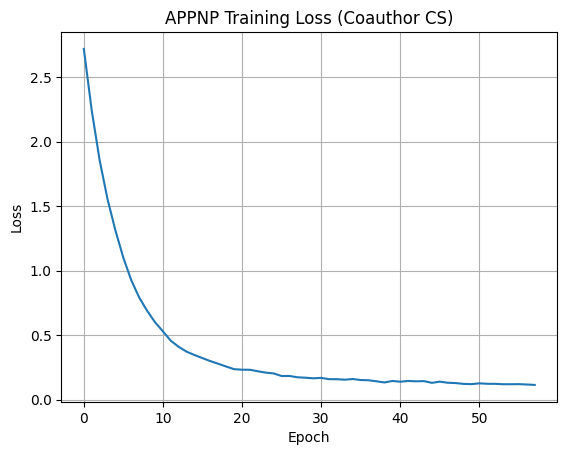

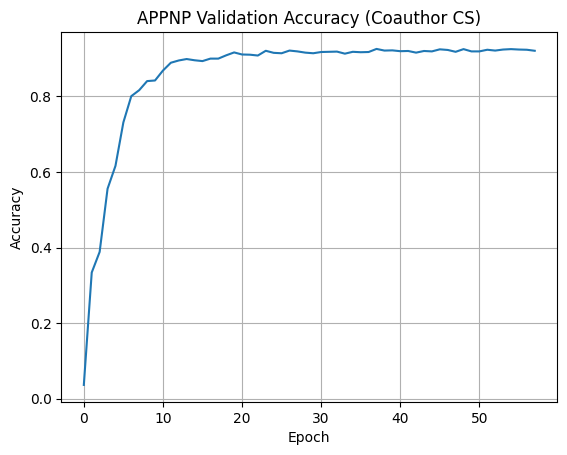

In [9]:
# Plots: training loss and validation accuracy
plt.figure()
plt.plot(train_losses)
plt.title("APPNP Training Loss (Coauthor CS)")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.show()

plt.figure()
plt.plot(val_accs)
plt.title("APPNP Validation Accuracy (Coauthor CS)")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.grid(True)
plt.show()

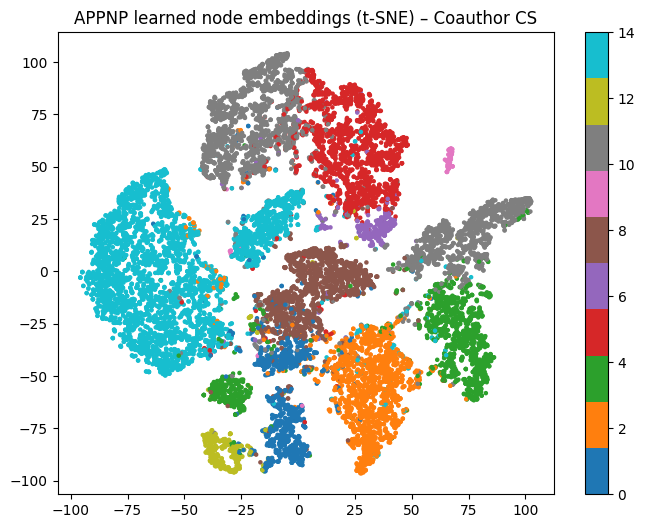

In [10]:
# t-SNE visualization of learned node embeddings
model.eval()
with torch.no_grad():
    logits = model(data.x, data.edge_index)
emb = logits.detach().cpu().numpy()

tsne = TSNE(n_components=2, learning_rate="auto", init="random", random_state=seed)
emb_2d = tsne.fit_transform(emb)

plt.figure(figsize=(8, 6))
plt.scatter(emb_2d[:, 0], emb_2d[:, 1], c=data.y.cpu(), cmap="tab10", s=5)
plt.title("APPNP learned node embeddings (t-SNE) – Coauthor CS")
plt.colorbar()
plt.show()
